In [47]:

import socket, sys
socket.gethostname(), sys.executable
### init1 degil de bunu baz almaliyim btw
### readme'deki conflicti duzelt.
### wrap around mantigini bi duzelt. ama once mantigini anlaman lazim tabi. kendin karar ver nasil caliscagina.

('login3', '/project/def-nahee/kbas/pone_offline/graphnet_env/bin/python')

#  0 ) Imports & Notes & configuration

In [48]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [49]:
zenith_test_predictions_path = Path("zenith") / "test_predictions.csv"
zenith_metrics_path = Path("zenith") / "metrics.csv"
df_zenith_test_predictions = pd.read_csv(zenith_test_predictions_path)
df_zenith_metrics = pd.read_csv(zenith_metrics_path)



# 1) test_predictions.csv

Flow:
- 1.1) Confirm columns / NaNs / Infs.
- 1.2) Look at the global residual histogram.
- 1.3) Check residual vs true angle (trend + spread).
- 1.4) Quantify resolution with **W** (both equal-width and equal-population bins).
- 1.5) Assess bias with median residual and pred/true ratio.   ## bunu acaba radian ile mi yapsam


## a)  Confirm columns / NaNs / Infs.

In [50]:
print("shape:", df_zenith_test_predictions.shape)
print("columns:", list(df_zenith_test_predictions.columns))

shape: (41311, 8)
columns: ['true_zenith_radian', 'pred_zenith_radian', 'true_zenith_degree', 'pred_zenith_degree', 'kappa', 'event_id', 'residual_zenith_radian', 'residual_zenith_degree']


In [51]:
numeric_cols = df_zenith_test_predictions.select_dtypes(include=[np.number]).columns
minmax = df_zenith_test_predictions[numeric_cols].agg(["min", "max"]).T

print(minmax)

                              min            max
true_zenith_radian       0.005549       3.129967
pred_zenith_radian       0.001845       3.141569
true_zenith_degree       0.317949     179.333893
pred_zenith_degree       0.105709     179.998627
kappa                    0.032206     185.591354
event_id                18.000000  402910.000000
residual_zenith_radian  -1.698707       1.746825
residual_zenith_degree -97.328728     100.085724


##### Column ranges (min / max)

The table above reports the **minimum** and **maximum** value observed in each **numeric** column of `df_zenith_test_predictions`.

**Units**
- `true_zenith` and `pred_zenith` are in **radians** (expected physical range: \[0, π\]).
- `abs_error_deg` is in **degrees**.
- `kappa` is **dimensionless** (concentration parameter).
- `event_id` is an **integer identifier** (unitless).

In [52]:
print("Rows:", len(df_zenith_test_predictions))
print("\nNaN counts (all columns):")
print(df_zenith_test_predictions.isna().sum())

Rows: 41311

NaN counts (all columns):
true_zenith_radian        0
pred_zenith_radian        0
true_zenith_degree        0
pred_zenith_degree        0
kappa                     0
event_id                  0
residual_zenith_radian    0
residual_zenith_degree    0
dtype: int64


In [53]:
# Inf / -Inf counts in numeric columns (auto)
num_df = df_zenith_test_predictions.apply(pd.to_numeric, errors="coerce")

inf_pos = np.isposinf(num_df).sum()
inf_neg = np.isneginf(num_df).sum()
inf_any = np.isinf(num_df).sum()

out = pd.DataFrame({
    "+inf": inf_pos,
    "-inf": inf_neg,
    "any_inf": inf_any
}).sort_values("any_inf", ascending=False)

print("Inf counts (numeric columns):")
print(out)

Inf counts (numeric columns):
                        +inf  -inf  any_inf
true_zenith_radian         0     0        0
pred_zenith_radian         0     0        0
true_zenith_degree         0     0        0
pred_zenith_degree         0     0        0
kappa                      0     0        0
event_id                   0     0        0
residual_zenith_radian     0     0        0
residual_zenith_degree     0     0        0


In [54]:
# ----  global W over the full test set ----
r = df_zenith_test_predictions["residual_zenith_degree"].to_numpy(dtype=float)
p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
W = (p84 - p16) / 2

print(f"p16={p16:.4f}, p50={p50:.4f}, p84={p84:.4f}, W={W:.4f}")

p16=-7.0891, p50=-0.0053, p84=7.4161, W=7.2526


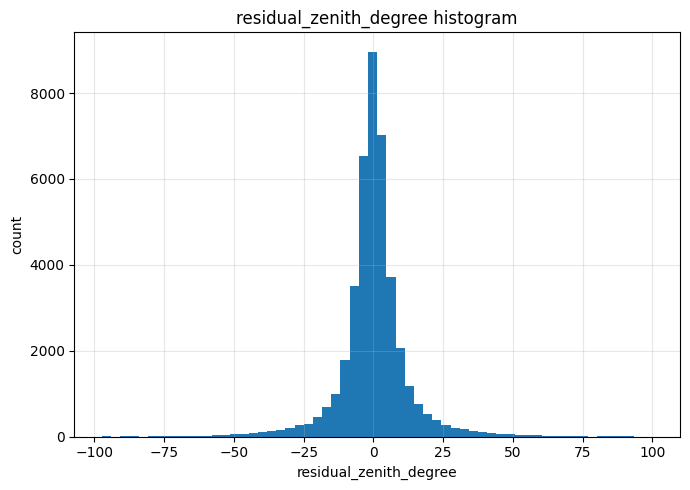

In [55]:
# ---- abs_error_deg histogram (full test set) ----

plt.figure(figsize=(7, 5))
plt.hist(r, bins=60)
plt.xlabel("residual_zenith_degree")
plt.ylabel("count")
plt.title("residual_zenith_degree histogram")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Residual vs true zenith (with binned median)

This diagnostic shows how the **zenith residual** behaves across the zenith range:

- Each blue point is one event:  
  $r = \widehat{\theta} - \theta_\mathrm{true}$  
  where $\theta$ is the zenith angle in **degrees**.
- The horizontal line at $r=0$ is the **ideal** case (no bias).
- The red curve is the **binned median** of the residual, which highlights the typical trend.

What to look for:
- If the red curve stays near 0 → the model is **well-calibrated** across zenith.
- If it drifts above 0 → systematic **overestimation** of zenith.
- If it drifts below 0 → systematic **underestimation** of zenith.
- If the vertical spread increases for certain zenith ranges → **worsening resolution** in those regions (larger event-to-event scatter).


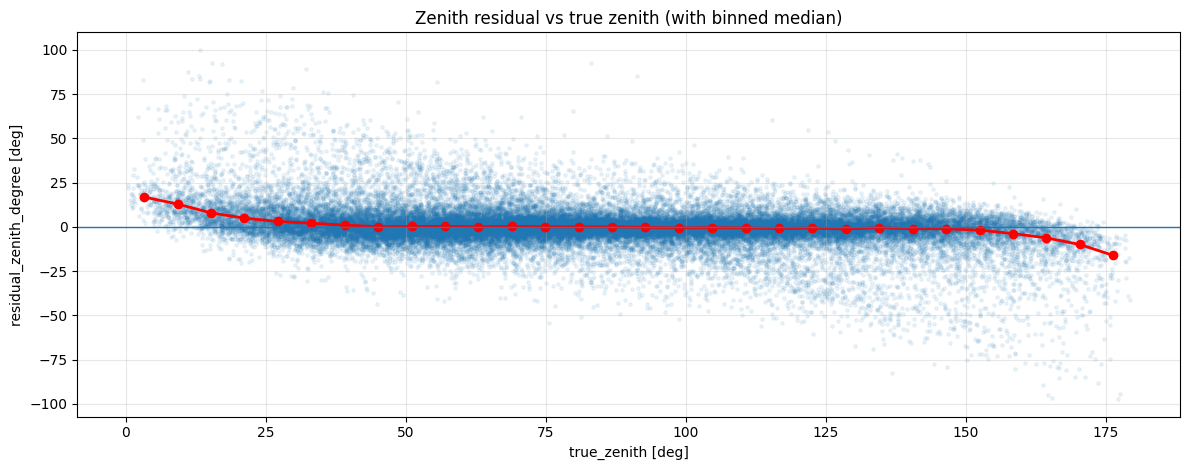

In [56]:
# ---- Zenith: residual vs true_zenith scatter + binned median (NO subsample) ----

x = df_zenith_test_predictions["true_zenith_degree"].to_numpy(dtype=float)


plt.figure(figsize=(12, 4.8))
plt.scatter(x, r, s=6, alpha=0.08)

# binned median (equal-width in x)
n_bins = 30
bins = np.linspace(x.min(), x.max(), n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

median_r = []
for left, right in zip(bins[:-1], bins[1:]):
    m = (x >= left) & (x < right) if right != bins[-1] else (x >= left) & (x <= right)
    median_r.append(np.median(r[m]) if np.any(m) else np.nan)

median_r = np.array(median_r, dtype=float)

plt.plot(bin_centers, median_r, marker="o", linewidth=2, color="r")
plt.axhline(0.0, linestyle="-", linewidth=1)

plt.xlabel("true_zenith [deg]")
plt.ylabel("residual_zenith_degree [deg]")
plt.title("Zenith residual vs true zenith (with binned median)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Calibration scatter (predicted vs true)

A calibration plot compares the model prediction to the truth directly:

- x-axis: $\theta_\mathrm{true}$ (zenith in **radians**)  
- y-axis: $\widehat{\theta}$ (predicted zenith in **radians**)

The reference line $y=x$ corresponds to perfect calibration.
Points below the line indicate underestimation; above the line indicate overestimation.


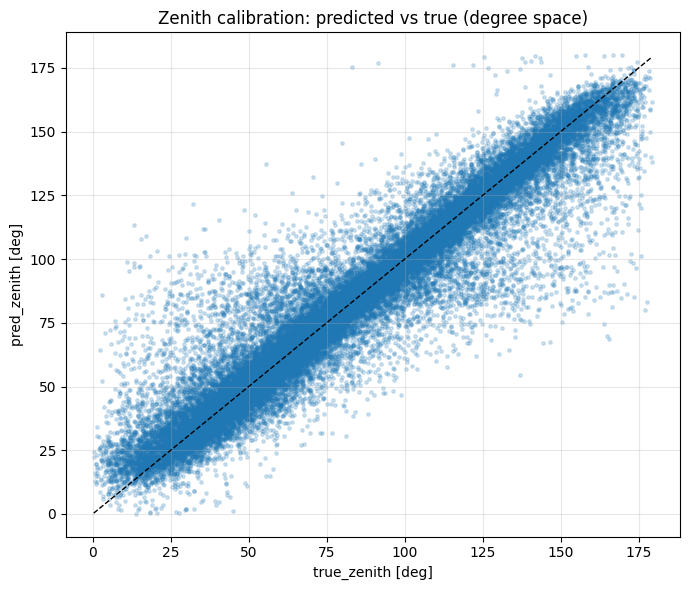

In [57]:
# ---- Zenith: calibration scatter (pred_zenith vs true_zenith) ----

plt.figure(figsize=(7, 6))

plt.scatter(
    df_zenith_test_predictions["true_zenith_degree"],
    df_zenith_test_predictions["pred_zenith_degree"],
    s=6, alpha=0.2
)

xmin = df_zenith_test_predictions["true_zenith_degree"].min()
xmax = df_zenith_test_predictions["true_zenith_degree"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)  # y=x

plt.xlabel("true_zenith [deg]")
plt.ylabel("pred_zenith [deg]")
plt.title("Zenith calibration: predicted vs true (degree space)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

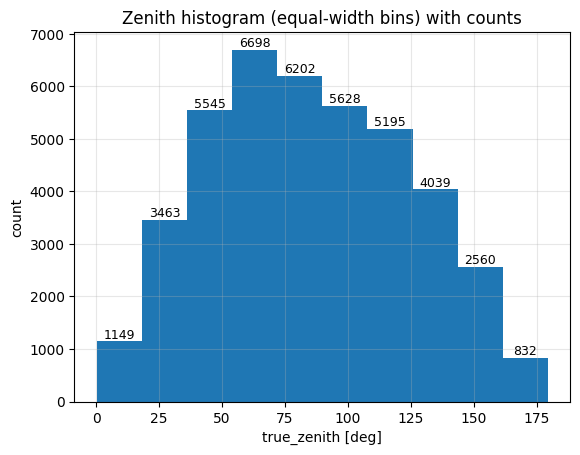

In [58]:
# ---- Zenith: histogram with counts annotated on top of bars ----
n_bins_zenith = 10
bins_zenith = np.linspace(
    df_zenith_test_predictions["true_zenith_degree"].min(),
    df_zenith_test_predictions["true_zenith_degree"].max(),
    n_bins_zenith + 1,
)
values = df_zenith_test_predictions["true_zenith_degree"].to_numpy(dtype=float)

plt.figure()
counts, edges, patches = plt.hist(values, bins=bins_zenith)

# annotate each bar with its count
for c, left, right in zip(counts, edges[:-1], edges[1:]):
    if c <= 0:
        continue
    x = 0.5 * (left + right)
    plt.text(x, c, f"{int(c)}", ha="center", va="bottom", fontsize=9)

plt.xlabel("true_zenith [deg]")
plt.ylabel("count")
plt.title("Zenith histogram (equal-width bins) with counts")
plt.grid(True, alpha=0.3)
plt.show()

In [59]:
# ---- Zenith: W table per zenith bin (using residual_zenith in radians) ----

df_zenith_w_rows = []


# Use histogram edges from your zenith hist cell:
# counts, edges, patches = plt.hist(...)
# If your variable name is edges_zenith, replace edges -> edges_zenith below.
for left, right in zip(edges[:-1], edges[1:]):
    # match matplotlib hist logic: [left, right) except last bin includes right
    if right == edges[-1]:
        mask = (df_zenith_test_predictions["true_zenith_degree"] >= left) & (df_zenith_test_predictions["true_zenith_degree"] <= right)
    else:
        mask = (df_zenith_test_predictions["true_zenith_degree"] >= left) & (df_zenith_test_predictions["true_zenith_degree"] < right)


    if r.size == 0:
        continue

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (left + right)

    df_zenith_w_rows.append({
        "Zbin": f"({left:.3f}, {right:.3f}]",
        "Z_center_deg": center,
        "count": int(r.size),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_zenith_W_table = pd.DataFrame(df_zenith_w_rows)
df_zenith_W_table

,Zbin,Z_center_deg,count,p16,p50,p84,W
0,"(0.318, 18.220]",9.268746,41311,-7.089112,-0.005348,7.416073,7.252593
1,"(18.220, 36.121]",27.170341,41311,-7.089112,-0.005348,7.416073,7.252593
2,"(36.121, 54.023]",45.071935,41311,-7.089112,-0.005348,7.416073,7.252593
3,"(54.023, 71.924]",62.973529,41311,-7.089112,-0.005348,7.416073,7.252593
4,"(71.924, 89.826]",80.875124,41311,-7.089112,-0.005348,7.416073,7.252593
5,"(89.826, 107.728]",98.776718,41311,-7.089112,-0.005348,7.416073,7.252593
6,"(107.728, 125.629]",116.678313,41311,-7.089112,-0.005348,7.416073,7.252593
7,"(125.629, 143.531]",134.579907,41311,-7.089112,-0.005348,7.416073,7.252593
8,"(143.531, 161.432]",152.481501,41311,-7.089112,-0.005348,7.416073,7.252593
9,"(161.432, 179.334]",170.383096,41311,-7.089112,-0.005348,7.416073,7.252593


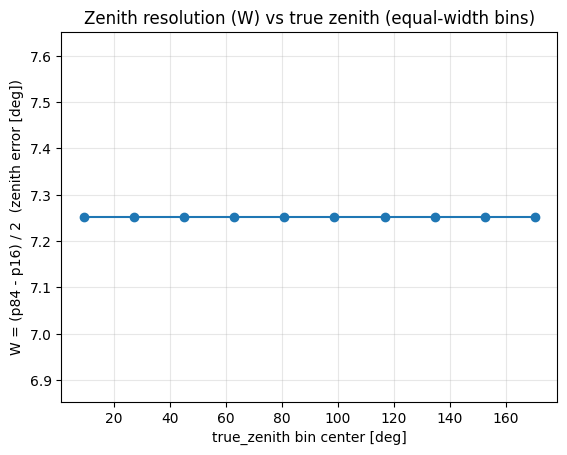

In [60]:
# ---- Zenith: plot W vs true zenith (equal-width bins) ----

plt.figure()
plt.plot(df_zenith_W_table["Z_center_deg"], df_zenith_W_table["W"], marker="o")
plt.xlabel("true_zenith bin center [deg]")
plt.ylabel("W = (p84 - p16) / 2  (zenith error [deg])")
plt.title("Zenith resolution (W) vs true zenith (equal-width bins)")
plt.grid(True, alpha=0.3)
plt.show()

### Interpreting the W trend (equal-width bins)

In the **equal-width** zenith binning, the number of events per bin is **not uniform**.  
Depending on the underlying event distribution, some zenith regions may contain **much fewer events**, so the quantile estimates (p16/p50/p84) become **statistically unstable**. This can artificially inflate the width  
$W = (p84 - p16)/2$ and make it look like the resolution worsens in those zenith ranges.

To reduce this sampling effect, we next repeat the same analysis using **equal-population bins** (i.e., bins with approximately the same number of events) and compare the results.


In [61]:
# ---- create equal-population bins (qcut) ----

n_qbins_zenith = 10

df_zenith_test_predictions["Zbin_q"] = pd.qcut(
    df_zenith_test_predictions["true_zenith_degree"],
    q=n_qbins_zenith,
    duplicates="drop",
)

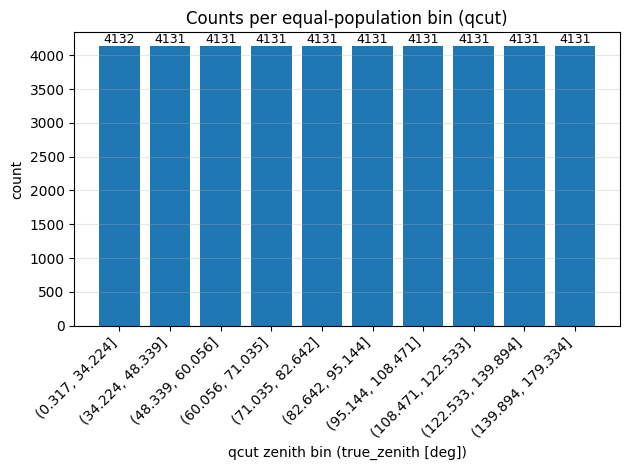

In [62]:
# ---- plot counts per qcut bin ----

bin_counts_q = df_zenith_test_predictions["Zbin_q"].value_counts().sort_index()

plt.figure()
plt.bar(range(len(bin_counts_q)), bin_counts_q.to_numpy())
plt.xticks(
    range(len(bin_counts_q)),
    [str(i) for i in bin_counts_q.index],
    rotation=45,
    ha="right",
)
plt.xlabel("qcut zenith bin (true_zenith [deg])")
plt.ylabel("count")
plt.title("Counts per equal-population bin (qcut)")
plt.grid(True, axis="y", alpha=0.3)

# annotate counts on top of bars
for i, c in enumerate(bin_counts_q.to_numpy()):
    plt.text(i, c, str(int(c)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

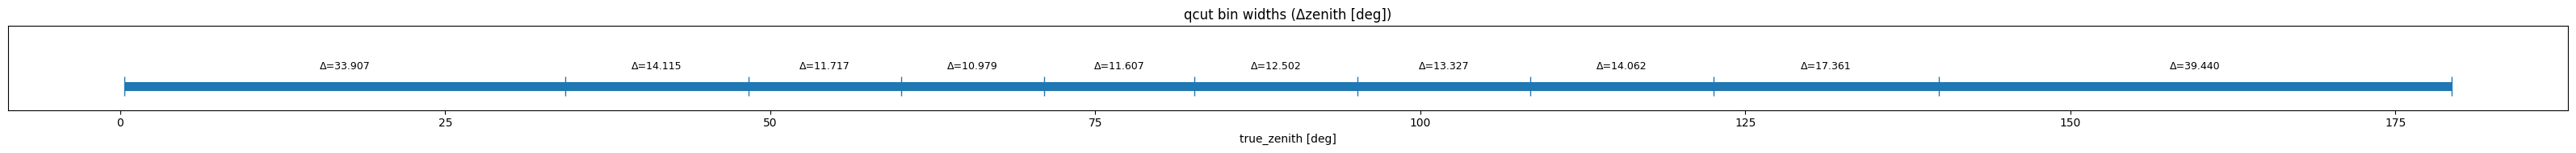

In [63]:
# ---- Visualize qcut bin widths only (in zenith radian space) ----

# intervals in correct order
intervals = bin_counts_q.index  # IntervalIndex from your existing bin_counts_q

lefts  = np.array([iv.left for iv in intervals], dtype=float)
rights = np.array([iv.right for iv in intervals], dtype=float)
widths = rights - lefts
centers = (lefts + rights) / 2

plt.figure(figsize=(32, 2))

# draw each bin as a horizontal segment
for L, R, w, x in zip(lefts, rights, widths, centers):
    plt.hlines(0, L, R, linewidth=8)
    plt.text(x, 0.12, f"Δ={w:.3f}", ha="center", va="bottom", fontsize=9)

# draw bin boundaries as small ticks
for x in lefts:
    plt.vlines(x, -0.08, 0.08, linewidth=1)
plt.vlines(rights[-1], -0.08, 0.08, linewidth=1)

plt.yticks([])
plt.xlabel("true_zenith [deg]")
plt.title("qcut bin widths (Δzenith [deg])")
plt.ylim(-0.2, 0.5)
plt.tight_layout()
plt.show()

In [64]:
# ---- Zenith: p16/p50/p84 and W per qcut bin (use groupby directly; no remasking) ----

rows_zenith_q = []
for iv, g in df_zenith_test_predictions.groupby("Zbin_q", observed=True):
    r = (g["residual_zenith_degree"]).to_numpy(dtype=float)  # residual in radians

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (float(iv.left) + float(iv.right))

    rows_zenith_q.append({
        "Zbin_q": str(iv),
        "Z_center_deg": center,
        "count": int(len(g)),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_zenith_W_table_q = pd.DataFrame(rows_zenith_q).sort_values("Z_center_deg")
df_zenith_W_table_q

,Zbin_q,Z_center_deg,count,p16,p50,p84,W
0,"(0.317, 34.224]",17.2705,4132,-2.688709,5.162102,18.434805,10.561757
1,"(34.224, 48.339]",41.2815,4131,-6.211018,0.735509,10.596453,8.403736
2,"(48.339, 60.056]",54.1975,4131,-6.427709,0.264403,8.595458,7.511584
3,"(60.056, 71.035]",65.5455,4131,-6.380576,0.186218,8.021496,7.201036
4,"(71.035, 82.642]",76.8385,4131,-5.737882,0.044840,6.108936,5.923409
5,"(82.642, 95.144]",88.8930,4131,-5.552285,-0.032983,5.171006,5.361646
6,"(95.144, 108.471]",101.8075,4131,-7.169763,-0.510563,5.017178,6.093471
7,"(108.471, 122.533]",115.5020,4131,-7.993041,-0.703632,4.855986,6.424514
8,"(122.533, 139.894]",131.2135,4131,-9.293502,-0.823789,5.275302,7.284402
9,"(139.894, 179.334]",159.6140,4131,-18.105537,-2.966911,3.882438,10.993988


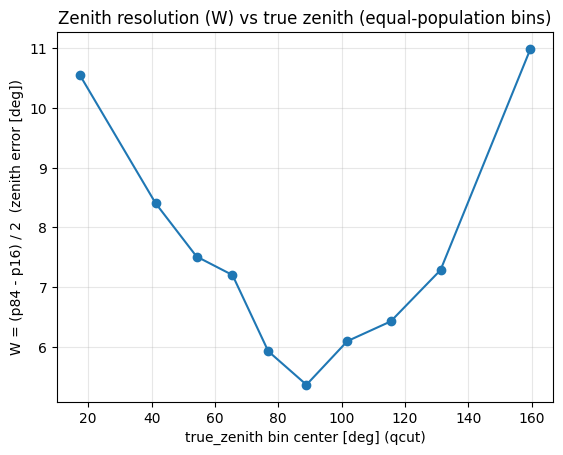

In [65]:
# ---- Zenith: plot W vs true zenith (qcut bins) ----

plt.figure()
plt.plot(df_zenith_W_table_q["Z_center_deg"], df_zenith_W_table_q["W"], marker="o")
plt.xlabel("true_zenith bin center [deg] (qcut)")
plt.ylabel("W = (p84 - p16) / 2  (zenith error [deg])")
plt.title("Zenith resolution (W) vs true zenith (equal-population bins)")
plt.grid(True, alpha=0.3)
plt.show()

#### Definition of `residual_zenith` (degrees)

`residual_zenith_degree` is defined as:

$$
\mathrm{residual\_zenith\_degree}
=
\hat{\theta}_{\mathrm{zenith}}^{(\deg)}
-
\theta_{\mathrm{zenith,true}}^{(\deg)}
$$

In the CSV this corresponds to:

$$
\mathrm{residual\_zenith\_degree}
=
\mathrm{pred\_zenith\_degree}
-
\mathrm{true\_zenith\_degree}
$$



#### Interpreting the sign of `residual_zenith_degree`

- `residual_zenith_degree = 0` → perfect prediction  
- `residual_zenith_degree > 0` → the model predicts a **larger zenith angle** than truth  
- `residual_zenith_degree < 0` → the model predicts a **smaller zenith angle** than truth  

**Note:** Zenith is not periodic like azimuth, so a simple difference usually makes sense.  
Typical range: $\theta_{\deg} \in [0,180^\circ]$  
$\Rightarrow$ residual roughly in $[-180^\circ, 180^\circ]$.



#### Quantiles: p16, p50, p84

To summarize the distribution of `residual_zenith_degree`:

- **p50** = median (middle value) → can be interpreted as **bias**
- **p16** and **p84** = the 16th and 84th percentiles  
  (If residuals were Gaussian, these would roughly correspond to $\pm 1\sigma$ around the median.)



#### Resolution proxy: `W`

I define a resolution-like width using the central 68% interval:

$W = \frac{p84 - p16}{2}$

Interpretation:

- Small $W$ → tighter residual distribution → **better resolution**
- Large $W$ → wider residual distribution → **worse resolution**


#### Zenith performance so far: resolution (W)

So far we focused on **resolution**, summarized by  
$W = (p84 - p16)/2$, computed from the **zenith residual** distribution  
$r = \widehat{\theta} - \theta_\mathrm{true}$ in each zenith bin (units: **angles**).

Resolution tells us **how wide** the error distribution is.

Next, we examine **bias**:  
Does the model systematically **overestimate** or **underestimate** the zenith angle, and does this depend on zenith?


#### Bias analysis — three complementary views

There are three simple and complementary ways to study bias:

1) **Median residual vs zenith**  
   Plot $p50(r)$ as a function of zenith, where  
   $r = \widehat{\theta} - \theta_\mathrm{true}$ (angles).  
   This is the most direct bias measure in angular space.

2) **Median absolute error vs zenith**  
   Plot the median of the absolute error (e.g., $p50(|r|)$ in degrees).  
   This makes the typical angular deviation easier to interpret than signed residuals.



### 1) Median residual vs zenith (angular bias)

If we define the zenith residual (in degrees) as  
$r = \widehat{\theta} - \theta_\mathrm{true}$,

then:

- $p50 \approx 0$ → unbiased in that zenith region  
- $p50 > 0$ → systematic overestimation of zenith  
- $p50 < 0$ → systematic underestimation of zenith


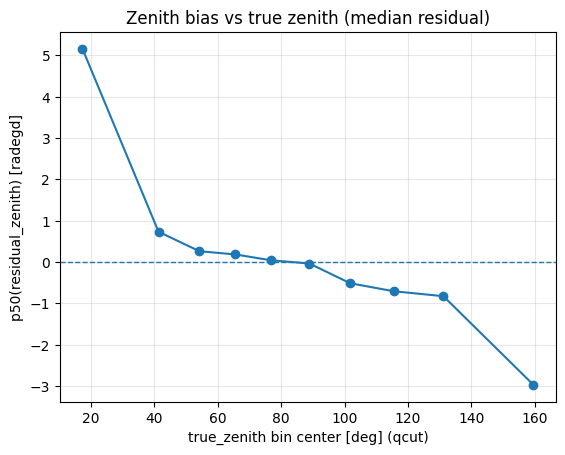

In [66]:
# ---- Zenith: bias vs true zenith (median residual, qcut bins) ----

plt.figure()
plt.plot(df_zenith_W_table_q["Z_center_deg"], df_zenith_W_table_q["p50"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("true_zenith bin center [deg] (qcut)")
plt.ylabel("p50(residual_zenith) [radegd]")
plt.title("Zenith bias vs true zenith (median residual)")
plt.grid(True, alpha=0.3)
plt.show()

### 2) Median absolute error vs zenith (intuitive)

Because the signed residual can cancel out, it is also useful to track the typical *magnitude* of the error:

- $p50(|r|)$ in **degrees** 

Interpretation:
- smaller values → better angular accuracy
- larger values → worse angular accuracy in that zenith region


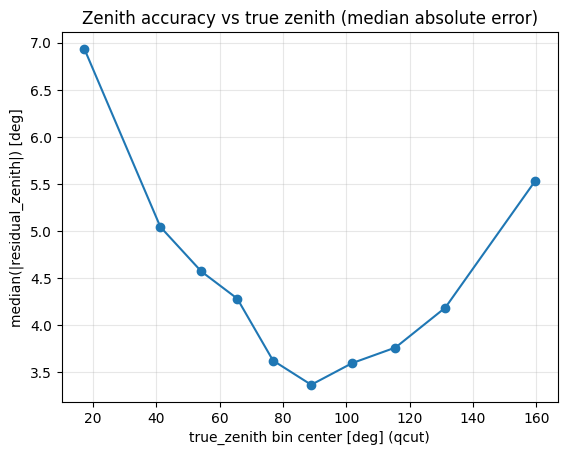

In [67]:
# ---- Zenith: median absolute error vs true zenith (qcut bins) ----

df_zenith_W_table_q["abs_p50_deg"] = np.nan  # keep style similar to your energy table edits

abs_rows = []
for iv, g in df_zenith_test_predictions.groupby("Zbin_q", observed=True):
    r = (g["pred_zenith_degree"] - g["true_zenith_degree"]).to_numpy(dtype=float)
    abs_rows.append((str(iv), np.median(np.abs(r))))

abs_map = dict(abs_rows)
df_zenith_W_table_q["abs_p50_deg"] = df_zenith_W_table_q["Zbin_q"].map(abs_map)

plt.figure()
plt.plot(df_zenith_W_table_q["Z_center_deg"], df_zenith_W_table_q["abs_p50_deg"], marker="o")
plt.xlabel("true_zenith bin center [deg] (qcut)")
plt.ylabel("median(|residual_zenith|) [deg]")
plt.title("Zenith accuracy vs true zenith (median absolute error)")
plt.grid(True, alpha=0.3)
plt.show()

# 2) metrics.csv

In [68]:
print("shape:", df_zenith_metrics.shape)
print("columns:", list(df_zenith_metrics.columns))

shape: (3, 13)
columns: ['epoch', 'train_loss', 'val_loss', 'lr', 'best_model_is_updated', 'val_residual_p16_deg', 'val_residual_p50_deg', 'val_residual_p84_deg', 'val_W_deg', 'val_kappa_p16', 'val_kappa_p50', 'val_kappa_p84', 'val_kappa_W']


In [69]:
df_zenith_metrics.head(5)

,epoch,train_loss,val_loss,lr,best_model_is_updated,val_residual_p16_deg,val_residual_p50_deg,val_residual_p84_deg,val_W_deg,val_kappa_p16,val_kappa_p50,val_kappa_p84,val_kappa_W
0,0,NaN,0.066668,0.000802,True,-15.355604,-2.646814,7.751536,11.553570,7.652787,12.039590,16.702179,4.524696
1,1,1.067349,-0.057009,0.000406,True,-10.112491,0.423055,10.147451,10.129971,9.220037,14.557570,23.338886,7.059424
2,2,0.134844,-0.493398,0.000010,True,-7.088128,0.058425,7.299465,7.193797,14.636106,47.159321,77.054337,31.209114


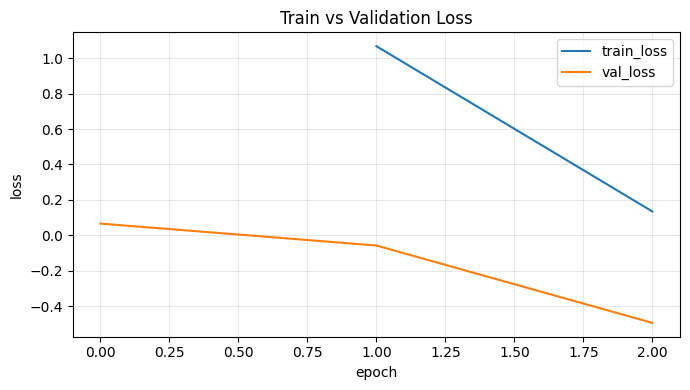

In [70]:
plt.figure(figsize=(7,4))
plt.plot(df_zenith_metrics["epoch"], df_zenith_metrics["train_loss"], label="train_loss")
plt.plot(df_zenith_metrics["epoch"], df_zenith_metrics["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()